In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas
from scipy.io import loadmat

# Load zebrafish tailbeat data and stimulus LED location information

In [2]:
data = pandas.read_csv('./behavioral_data/DataFrame_tailbeats_forward.csv') # raw tail beat response data
forward_masks = loadmat('./behavioral_data/Stimulus_masks_forward.mat')['data'][0][0] # masks indicating which LEDs are on for each stimulus
LED_coords = forward_masks[0][0][0]
LED_azimuths = LED_coords[0]
LED_elevations = LED_coords[1]
LED_number = LED_azimuths.shape[0]

# Set up
azimuth_ticks = [-180, -90, 0, 90, 180]
azimuth_tick_lims = (np.min(azimuth_ticks), np.max(azimuth_ticks))
elevation_ticks = [-90, -45, 0, 45, 90]
elevation_tick_lims = (np.min(elevation_ticks), np.max(elevation_ticks))
spherical_arena_coverage = 0.8558 #  fraction of full sphere covered by stimulation arena
stimulus_number = 19 #  number of different stimuli used in experiments (each covering different areas of sphere)

# Show LED illumination pattern for all stimuli

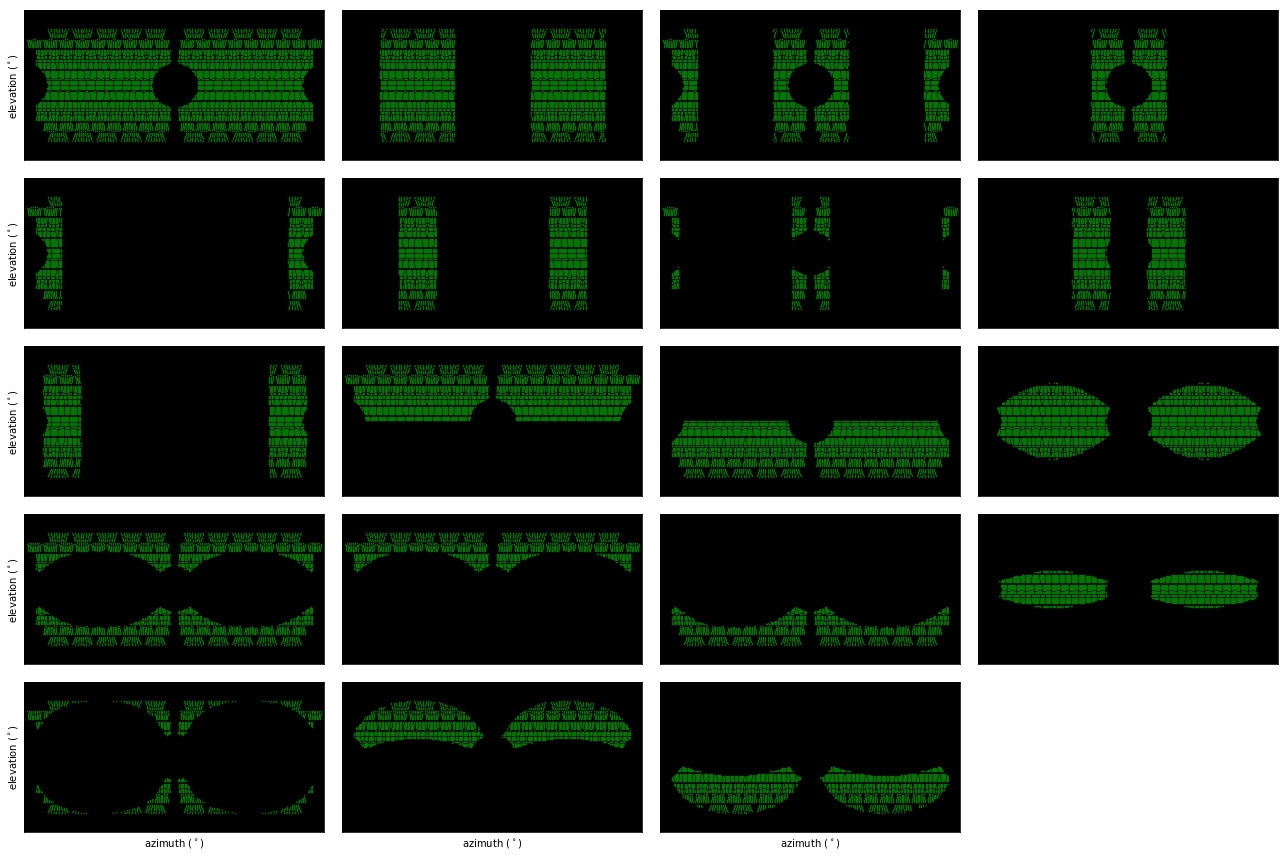

In [3]:
fig = plt.figure(figsize=(18,12), facecolor='w')
for stim in range(1,20):
    plt.subplot(5, 4, stim)
    mask = np.copy(forward_masks[stim][0][0][0]).astype(np.float64)
    mask[mask == 0] = np.nan
    plt.scatter(LED_azimuths, LED_elevations * mask, color='g', s=.25)
    plt.xlim(*azimuth_tick_lims)
    plt.ylim(*elevation_tick_lims)
    plt.gca().set_facecolor('k')
    plt.gca().set_aspect(1)
    plt.xticks([])
    plt.yticks([])
    if stim % 4 == 1:
        plt.ylabel('elevation ($^\circ$)')
    if stim > 16:
        plt.xlabel('azimuth ($^\circ$)')
plt.tight_layout()

# Function for calculating response heatmaps

In [23]:
def calculate_response_maps(df: pandas.DataFrame, scale_by_stimulus_coverage: bool = True) -> (np.ndarray, np.ndarray):
    # Calculate relative fish responses per LED and with stimulation "area" corrected for
    LED_resp_means = np.nan * np.ones((stimulus_number, LED_number))
    LED_resp_stds = np.nan * np.ones((stimulus_number, LED_number))

    # For each stimulus
    for i in range(0, stimulus_number):
        stim = i + 1
        mask = np.copy(forward_masks[stim][0][0][0]).squeeze().astype(bool)
        stim_key = f's{str(stim).zfill(2)}'

        if scale_by_stimulus_coverage:
            scale = 1. / (spherical_arena_coverage * 4 * np.pi * mask.sum() / LED_number) #  1/steradians
        else:
            scale = 1.

        # Response mean
        LED_resp_means[i, mask] = df[df.stimulus == stim_key].tailbeat_mean / single_trial_duration * scale

        # Response SD
        LED_resp_stds[i, mask] = df[df.stimulus == stim_key].tailbeat_std / single_trial_duration * scale

    # Calculate mean response per LED and mean of SDs
    resp_means = np.nanmean(LED_resp_means, axis=0)
    resp_stddevs = np.nanmean(LED_resp_stds, axis=0)

    return resp_means, resp_stddevs


## Individual response heatmaps

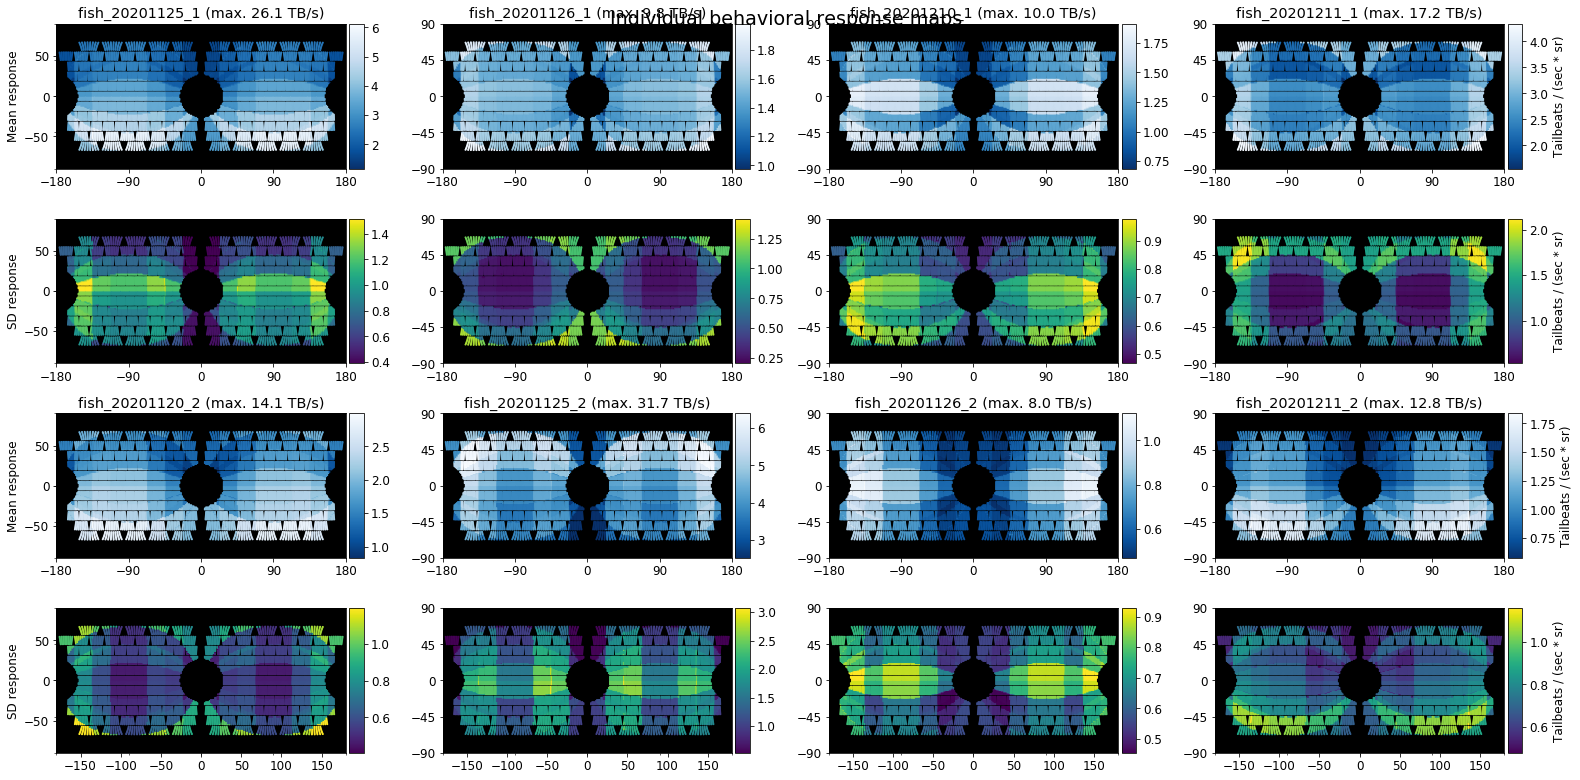

In [24]:
# Calculate across-trial mean tailbeat count (only use forward stimulus direction)
grp_trials = data.groupby(['date', 'fish', 'stimulus'])
df_trials = pandas.DataFrame()
df_trials['tailbeat_mean'] = grp_trials.tail_beat.mean()
df_trials['tailbeat_std'] = grp_trials.tail_beat.std()
df_trials = df_trials.reset_index()
# df_trials.to_csv('data_avg_across_repeats.csv')

# Select single fish data averaged across repeats
fish_grps = df_trials.groupby(['fish', 'date'])

# Show individual fish response map
nrows, ncols = 4, 4
single_trial_duration = 6 # s
fig, axes = plt.subplots(nrows, ncols, figsize=(22, 11), facecolor='w')
plt.rcParams['font.size'] = '16'
fig.suptitle('Individual behavioral response maps')
plt.rcParams['font.size'] = '12'
ax_idx = 0
for fish_keys, fish_idcs in fish_grps.groups.items():
    # Select axes
    row_idx = ax_idx // ncols * 2
    col_idx = ax_idx % ncols
    ax_mean = axes[row_idx, col_idx]
    ax_mean.set_facecolor('k')
    ax_std = axes[row_idx + 1, col_idx]
    ax_std.set_facecolor('k')

    # Select fish
    df_onefish = df_trials.loc[fish_idcs]

    # Set title
    max_tailbeat = df_onefish.tailbeat_mean.max()
    ax_mean.set_title(f'fish_{fish_keys[1]}_{fish_keys[0]} (max. {max_tailbeat/single_trial_duration:.1f} TB/s)')

    # Calculate fish-specific response maps
    resp_means, resp_stddevs = calculate_response_maps(df_onefish)

    # Plot maps
    scatter_mean = ax_mean.scatter(np.squeeze(LED_azimuths), np.squeeze(LED_elevations), c=np.squeeze(resp_means), cmap='Blues_r', s=1.)
    scatter_std = ax_std.scatter(np.squeeze(LED_azimuths), np.squeeze(LED_elevations), c=np.squeeze(resp_stddevs), s=1.)

    # Add colorbars
    divider = make_axes_locatable(ax_mean)
    cax_mean = divider.append_axes('right', size='5%', pad=0.05)
    cbar_mean = fig.colorbar(mappable=scatter_mean, cax=cax_mean, orientation='vertical')

    divider = make_axes_locatable(ax_std)
    cax_std = divider.append_axes('right', size='5%', pad=0.05)
    cbar_std = fig.colorbar(mappable=scatter_std, cax=cax_std, orientation='vertical')

    # Format axes
    # Format colorbar
    if col_idx == nrows -1:
        cbar_mean.set_label('Tailbeats / (sec * sr)')
        cbar_std.set_label('Tailbeats / (sec * sr)')

    # Set fixed aspect
    ax_mean.set_aspect(1)
    ax_std.set_aspect(1)

    # Format X
    ax_mean.set_xlim(*azimuth_tick_lims)
    ax_std.set_xlim(*azimuth_tick_lims)
    ax_mean.set_xticks(azimuth_ticks, [])
    if row_idx == nrows // 2:
        ax_std.set_xticks(azimuth_ticks, [f'{str(az)}$^\circ$' for az in azimuth_ticks])
    else:
        ax_std.set_xticks(azimuth_ticks, [])

    # Format Y
    ax_mean.set_ylim(*elevation_tick_lims)
    ax_std.set_ylim(*elevation_tick_lims)
    if ax_idx % ncols == 0:
        ax_mean.set_yticks(elevation_ticks, [f'{str(el)}$^\circ$' for el in elevation_ticks])
        ax_std.set_yticks(elevation_ticks, [f'{str(el)}$^\circ$' for el in elevation_ticks])
        ax_mean.set_ylabel('Mean response')
        ax_std.set_ylabel('SD response')
    else:
        ax_mean.set_yticks(elevation_ticks, [])
        ax_std.set_yticks(elevation_ticks, [])

    ax_idx += 1

fig.tight_layout()



## Average response heatmap

Text(0, 0.5, 'elevation ($^\\circ$)')

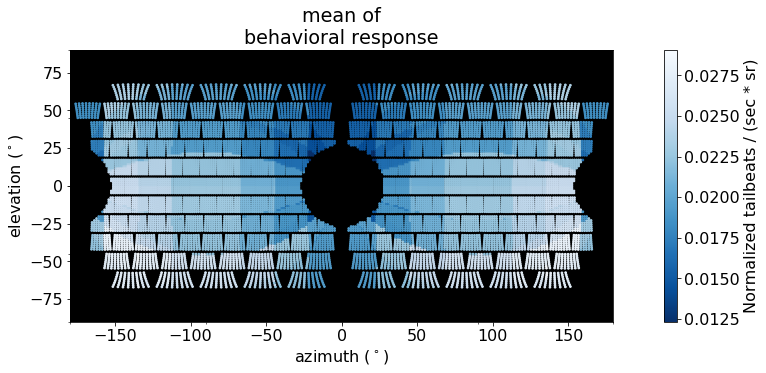

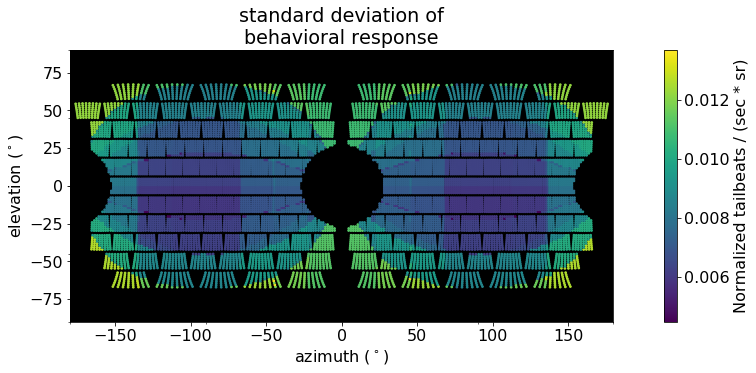

In [25]:
# Normalize each fish by strongest fish-specific across-trial response
grp_norm = df_trials.groupby(['date', 'fish'])
df_norm = pandas.DataFrame()
df_norm['stimulus'] = grp_norm.apply(lambda df: df.stimulus)
df_norm['tailbeat_norm'] = grp_norm.apply(lambda df: df.tailbeat_mean / df.tailbeat_mean.max())
df_norm = df_norm.reset_index()

# Calculate across-fish responses for stimuli (normalized)
grp_resp = df_norm.groupby(['stimulus'])
df_resp = pandas.DataFrame()
df_resp['tailbeat_mean'] = grp_resp.tailbeat_norm.mean()
df_resp['tailbeat_std'] = grp_resp.tailbeat_norm.std()
df_resp = df_resp.reset_index()

# Calculate across-fish average response maps
resp_means, resp_stddevs = calculate_response_maps(df_resp)

plt.rcParams['font.size'] = '16'

# mean
fig_mean, ax_mean = plt.subplots(figsize=(18, 5), facecolor='w')
scatter_mean = ax_mean.scatter(np.squeeze(LED_azimuths), np.squeeze(LED_elevations), c=np.squeeze(resp_means), cmap='Blues_r', s=3)
plt.colorbar(mappable=scatter_mean, label='Normalized tailbeats / (sec * sr)')
ax_mean.set_facecolor('k')
ax_mean.set_aspect(1)
ax_mean.set_xlim(*azimuth_tick_lims)
ax_mean.set_ylim(*elevation_tick_lims)
ax_mean.set_xticks(azimuth_ticks, [str(az) for az in azimuth_ticks])
ax_mean.set_yticks(elevation_ticks, [str(el) for el in elevation_ticks])
ax_mean.set_title(f'mean of\nbehavioral response')
ax_mean.set_xlabel('azimuth ($^\circ$)')
ax_mean.set_ylabel('elevation ($^\circ$)')
plt.savefig(f'./heatmap_mean_average.png', format='png')

# standard deviation
fig_std, ax_std = plt.subplots(figsize=(18, 5), facecolor='w')
scatter_std = ax_std.scatter(np.squeeze(LED_azimuths), np.squeeze(LED_elevations), c=np.squeeze(resp_stddevs), s=3)
plt.colorbar(mappable=scatter_std, label='Normalized tailbeats / (sec * sr)')
ax_std.set_facecolor('k')
ax_std.set_aspect(1)
ax_std.set_xlim(*azimuth_tick_lims)
ax_std.set_ylim(*elevation_tick_lims)
ax_std.set_xticks(azimuth_ticks, [str(az) for az in azimuth_ticks])
ax_std.set_yticks(elevation_ticks, [str(el) for el in elevation_ticks])
ax_std.set_title(f'standard deviation of\nbehavioral response')
ax_std.set_xlabel('azimuth ($^\circ$)')
ax_std.set_ylabel('elevation ($^\circ$)')

# plt.savefig(f'./heatmap_std_average.png', format='png')


# Elevation-only analysis

## Show LED illumination pattern for 5 stimuli used for the elevation-only analysis

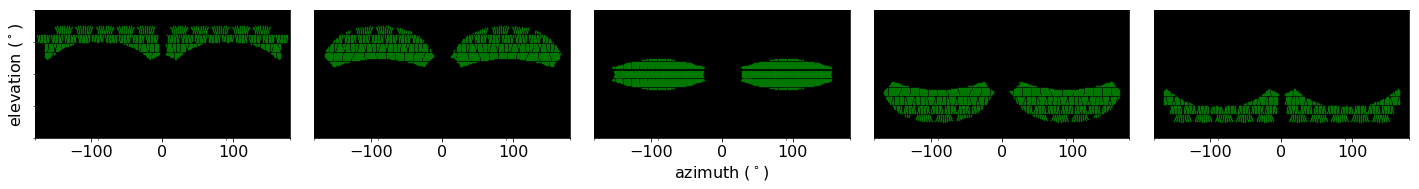

In [26]:
elevation_stimulus_ids = [14, 18, 16, 19, 15]

fig, axes = plt.subplots(1, len(elevation_stimulus_ids), figsize=(20, 5), facecolor='w')
for i, stim_id in enumerate(elevation_stimulus_ids):
    ax = axes[i]
    mask = np.copy(forward_masks[stim_id][0][0][0]).astype(np.float64)
    mask[mask == 0] = np.nan
    ax.scatter(LED_azimuths, LED_elevations * mask, color='g', s=.25)

    ax.set_xlim(*azimuth_tick_lims)
    ax.set_xticks(azimuth_ticks, [str(az) for az in azimuth_ticks])

    ax.set_ylim(*elevation_tick_lims)
    ax.set_yticks([])
    ax.set_facecolor('k')
    ax.set_aspect(1)

axes[len(elevation_stimulus_ids) // 2].set_xlabel('azimuth ($^\circ$)')
axes[0].set_yticks(elevation_ticks, [str(el) for el in elevation_ticks])
axes[0].set_ylabel('elevation ($^\circ$)')

plt.tight_layout()

## Individual fish responses and mean/sd as a function of LED elevation

Text(0, 0.5, 'Norm. tailbeats / (sec * sr)')

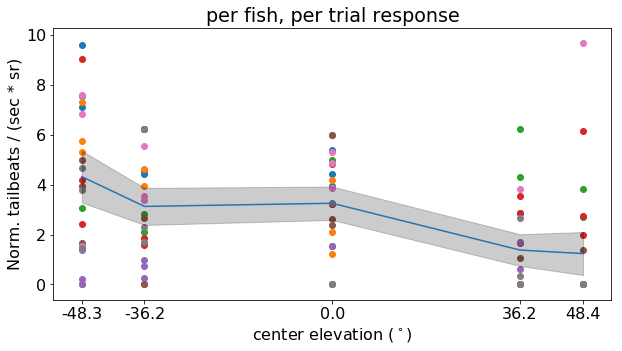

In [27]:
# Calculate normalized repeats for selected (pure elevation) stimuli
grp_trials_norm = data[data.stimulus.isin([f's{stim_id:02d}' for stim_id in elevation_stimulus_ids])].groupby(['date', 'fish'])
df_trials_norm = pandas.DataFrame()
df_trials_norm['stimulus'] = grp_trials_norm.apply(lambda df: df.stimulus)
df_trials_norm['repeat'] = grp_trials_norm.apply(lambda df: df.repeat)
df_trials_norm['tailbeat_norm'] = grp_trials_norm.apply(lambda df: df.tail_beat / df.tail_beat.max())
df_trials_norm = df_trials_norm.reset_index()

# Calculate and add center azimuth for each stimulus
df_trials_norm['center_elevation'] = np.nan
for stim_id in elevation_stimulus_ids:
    mask = np.copy(forward_masks[stim_id][0][0][0]).astype('float')
    mask[mask==0] = np.nan
    selection = df_trials_norm.stimulus == f's{stim_id:02d}'
    df_trials_norm.loc[selection, 'center_elevation'] = np.nanmean(mask * LED_elevations)
    # Correct for stimulation area
    df_trials_norm.loc[selection, 'tailbeat_norm'] *= spherical_arena_coverage * 4 * np.pi * LED_number / np.isfinite(mask).sum()  / single_trial_duration

# Plot
plt.figure(figsize=(10,5), facecolor='w')
grp_fish = df_trials_norm.groupby(['date', 'fish'])
# Fish datapoints for all repeats
for fish_keys, fish_idcs in grp_fish.groups.items():
    df_onefish = df_trials_norm.iloc[fish_idcs]
    plt.scatter(df_onefish.center_elevation, df_onefish.tailbeat_norm)

# Mean and SD
grp_by_elevation = df_trials_norm.groupby(['center_elevation'])
df_elevations = pandas.DataFrame()
df_elevations['tailbeat_mean'] = grp_by_elevation.tailbeat_norm.mean()
df_elevations['tailbeat_stderr'] = grp_by_elevation.tailbeat_norm.std() / np.sqrt(len(grp_fish))

plt.plot(df_elevations.index, df_elevations.tailbeat_mean)
plt.fill_between(df_elevations.index,
                 df_elevations.tailbeat_mean - df_elevations.tailbeat_stderr,
                 df_elevations.tailbeat_mean + df_elevations.tailbeat_stderr,
                 color='k', alpha=.2)
plt.xticks(df_elevations.index, [f'{el:.1f}' for el in df_elevations.index])
plt.title('per fish, per trial response')
plt.xlabel('center elevation ($^\circ$)')
plt.ylabel('Norm. tailbeats / (sec * sr)')

# plt.savefig(f'./elevation_dependent_responses.png', format='png')